<a href="https://colab.research.google.com/github/AndyCatruna/Vision-Summer-School/blob/main/Lab02_ConvNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

In this lab we will explore Convolutional Neural Networks for image classification.

Necessary imports

In [1]:
import sys

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader

We will use the CIFAR10 dataset which contains 32x32 images of 10 different classes.

In [2]:
# TODO for Exercise 3 - Add more transforms that act as image augmentations

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.RandomAffine(10), transforms.RandomAffine(80),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256,
                                          shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=256,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 97370227.90it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We plot some images from the dataset in order to get an idea of how they look.

   horse     deer      car    truck    plane     bird    horse    truck


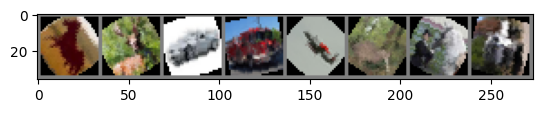

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(8)))

We define the device on which we will train the models. For this lab you should have GPU execution enabled. Training the models on cpu will take too much time.

If the models still take too much time to train, you can try to increase the batch size value in the dataloaders (if you increase it too much you might get "Out of memory error").

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We define a training epoch in which we iterate through all the data in the training set and update the model.

In [5]:
def train_epoch(model, dataloader, device, optimizer, criterion, epoch):
    model.train()

    total_train_loss = 0.0
    dataset_size = 0

    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)
    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_train_loss / dataset_size, 2)
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss)


    return epoch_loss

We define the validation function in which the model is tested on unseen images.

In [6]:
def valid_epoch(model, dataloader, device, criterion, epoch):
    model.eval()

    total_val_loss = 0.0
    dataset_size = 0

    correct = 0

    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)
    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        pred = model(images)
        loss = criterion(pred, labels)

        _, predicted = torch.max(pred, 1)
        correct += (predicted == labels).sum().item()

        total_val_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_val_loss / dataset_size, 2)

        accuracy = np.round(100 * correct / dataset_size, 2)

        bar.set_postfix(Epoch=epoch, Valid_Acc=accuracy, Valid_Loss=epoch_loss)

    return accuracy, epoch_loss

We define the function that receives the model and trains it with an optimizer and loss function (criterion) for a number of epochs.

In [7]:
def run_training(model, criterion, optimizer, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    top_accuracy = 0.0

    for epoch in range(num_epochs):

        train_loss = train_epoch(model, trainloader, device, optimizer, criterion, epoch)
        with torch.no_grad():
            val_accuracy, val_loss = valid_epoch(model, testloader, device, criterion, epoch)
            if val_accuracy > top_accuracy:
                print(f"Validation Accuracy Improved ({top_accuracy} ---> {val_accuracy})")
                top_accuracy = val_accuracy
        print()

#### Fully Connected Neural Network

We first train a fully connected network on the images to compare it with the following CNNs. The fully connected neural network is not a very wise choice for images because we lose spatial information.

In [8]:
class FCNNet(nn.Module):
    def __init__(self):
        super(FCNNet, self).__init__()

        self.fc1 = nn.Linear(in_features=3 * 32 * 32, out_features=360)
        self.fc2 = nn.Linear(in_features=360, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=84)
        self.fc4 = nn.Linear(in_features=84, out_features=10)
        self.fc5 = nn.Linear(in_features=10, out_features = 10)
        # Activation function - can be replaced by other better functions (GELU, Mish etc.)
        self.activation = nn.GELU()

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)

        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        # Output is 10 scores, one for each class
        x = self.fc5(x)

        return x

In [9]:
learning_rate = 0.001
epochs = 10

model = FCNNet()
model.to(device)
criterion = nn.CrossEntropyLoss()

# Adam is an improved gradient descent algorithm
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [10]:
run_training(model, criterion, optimizer, epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 40/40 [00:12<00:00,  3.10it/s, Epoch=0, Valid_Acc=35.6, Valid_Loss=1.8]
Validation Accuracy Improved (0.0 ---> 35.58)

100%|██████████| 40/40 [00:12<00:00,  3.16it/s, Epoch=1, Valid_Acc=40.9, Valid_Loss=1.66]
Validation Accuracy Improved (35.58 ---> 40.88)

100%|██████████| 40/40 [00:12<00:00,  3.16it/s, Epoch=2, Valid_Acc=41.5, Valid_Loss=1.65]
Validation Accuracy Improved (40.88 ---> 41.46)

100%|██████████| 40/40 [00:13<00:00,  3.06it/s, Epoch=3, Valid_Acc=42.9, Valid_Loss=1.6]
Validation Accuracy Improved (41.46 ---> 42.93)

100%|██████████| 40/40 [00:12<00:00,  3.09it/s, Epoch=4, Valid_Acc=44.4, Valid_Loss=1.59]
Validation Accuracy Improved (42.93 ---> 44.39)

100%|██████████| 40/40 [00:12<00:00,  3.10it/s, Epoch=5, Valid_Acc=45.5, Valid_Loss=1.54]
Validation Accuracy Improved (44.39 ---> 45.47)

100%|██████████| 40/40 [00:12<00:00,  3.11it/s, Epoch=6, Valid_Acc=45.8, Valid_Loss=1.53]
Validation Accuracy Improved (45.47 ---> 45.76)

100

#### Custom Convolutional Network

We first construct a custom convolutional network. We use [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) to define a convolutional layer and [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).

Notice how the shape of the input **x** changes through convolutional layers and pooling layers. Convolution modifies the channel dimension based on the `out_channels` argument and the spatial dimension based on the dimension of the `kernel_size`. The spatial dimension of the output can also be modified based on the `padding` and `stride` arguments.

The spatial dimension is computed with this formula: [(W−K+2P)/S]+1.

* W is the input size - 32 (in first conv layer)
* K is the Kernel size - 5
* P is the padding - default 0
* S is the stride - default 1

You can check the full formula [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) in the 'Shape' section.

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # First conv layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=7)

        # Second conv layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)

        # Pooling layer - used after both layers of convolution
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Linear layers of the fully connected classifier
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

        # Activation function - can be replaced by other better functions (GELU, Mish etc.)
        self.activation = nn.GELU()

    def forward(self, x):
        # Convolutional Part

        # input - x shape - (3,32,32)
        x = self.activation(self.conv1(x))
        # After conv - x shape - (6,28,28)

        x = self.pool(x)
        # After pooling - x shape - (6,14,14)

        x = self.activation(self.conv2(x))
        # After conv - x shape - (16,10,10)

        x = self.pool(x)
        # After pooling - x shape - (16,5,5)

        # Flatten features for input to fully connected layers
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected part
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))

        # Output is 10 scores, one for each class
        x = self.fc3(x)

        return x

**Exercise 1** - Run the training. Play with hyperparameters and network structure and try to improve results

In [12]:
learning_rate = 0.01
epochs = 10

model = ConvNet()
model.to(device)
criterion = nn.CrossEntropyLoss()

# Adam is an improved gradient descent algorithm
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
run_training(model, criterion, optimizer, epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 40/40 [00:13<00:00,  2.95it/s, Epoch=0, Valid_Acc=40.7, Valid_Loss=1.64]
Validation Accuracy Improved (0.0 ---> 40.68)

100%|██████████| 40/40 [00:12<00:00,  3.13it/s, Epoch=1, Valid_Acc=43.8, Valid_Loss=1.56]
Validation Accuracy Improved (40.68 ---> 43.81)

100%|██████████| 40/40 [00:12<00:00,  3.10it/s, Epoch=2, Valid_Acc=45.8, Valid_Loss=1.52]
Validation Accuracy Improved (43.81 ---> 45.76)

100%|██████████| 40/40 [00:12<00:00,  3.14it/s, Epoch=3, Valid_Acc=44, Valid_Loss=1.54]

100%|██████████| 40/40 [00:12<00:00,  3.11it/s, Epoch=4, Valid_Acc=46.8, Valid_Loss=1.5]
Validation Accuracy Improved (45.76 ---> 46.84)

100%|██████████| 40/40 [00:12<00:00,  3.13it/s, Epoch=5, Valid_Acc=47.1, Valid_Loss=1.47]
Validation Accuracy Improved (46.84 ---> 47.06)

100%|██████████| 40/40 [00:12<00:00,  3.09it/s, Epoch=6, Valid_Acc=47.9, Valid_Loss=1.45]
Validation Accuracy Improved (47.06 ---> 47.94)

100%|██████████| 40/40 [00:12<00:00,  3.17it/s, Epoc

#### Off the shelf CNN - ResNet18

<img src="https://i.imgur.com/XwcnU5x.png" width=600px>

We do not need to manually construct new CNN models. There are available architectures in the [torchvision library](https://pytorch.org/vision/0.8/models.html) and in the [timm library](https://timm.fast.ai/). We can modify their output layers to fit our data and train them for our specific task.

For this example we use ResNet18 which is a lightweight version of ResNet. We modify the final layer to work with only 10 classes.

In [14]:
model = resnet18()

# ResNet is trained on ImageNet - 1000 classes. We modify the last layer to have only 10 classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features=in_features, out_features=10, bias=True)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

**Exercise 2** - Run the training. Play with hyperparameters and try to improve results.

In [15]:
run_training(model, criterion, optimizer, epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 40/40 [00:12<00:00,  3.16it/s, Epoch=0, Valid_Acc=35.9, Valid_Loss=1.79]
Validation Accuracy Improved (0.0 ---> 35.9)

100%|██████████| 40/40 [00:12<00:00,  3.12it/s, Epoch=1, Valid_Acc=44.1, Valid_Loss=1.55]
Validation Accuracy Improved (35.9 ---> 44.12)

100%|██████████| 40/40 [00:12<00:00,  3.14it/s, Epoch=2, Valid_Acc=48.8, Valid_Loss=1.43]
Validation Accuracy Improved (44.12 ---> 48.75)

100%|██████████| 40/40 [00:12<00:00,  3.12it/s, Epoch=3, Valid_Acc=50.5, Valid_Loss=1.37]
Validation Accuracy Improved (48.75 ---> 50.51)

100%|██████████| 40/40 [00:12<00:00,  3.08it/s, Epoch=4, Valid_Acc=53.4, Valid_Loss=1.3]
Validation Accuracy Improved (50.51 ---> 53.42)

100%|██████████| 40/40 [00:12<00:00,  3.08it/s, Epoch=5, Valid_Acc=57.1, Valid_Loss=1.21]
Validation Accuracy Improved (53.42 ---> 57.09)

100%|██████████| 40/40 [00:12<00:00,  3.13it/s, Epoch=6, Valid_Acc=58.4, Valid_Loss=1.17]
Validation Accuracy Improved (57.09 ---> 58.4)

100%|

#### ResNet18 with weights pretrained on ImageNet

We do not need to train the model from scratch. We can use weights of models pretrained on large datasets and fine-tune them for our task.

Doing this can significantly improve the final accuracy, especially when we have a small amount of training data.

In this example we start from weights of a ResNet18 pretrained on ImageNet (1M images). We can see that the model performs much better.

However, starting from ImageNet pretrained weights is not allowed in the competition 😉

In [16]:
model = resnet18(pretrained=True)

# ResNet is trained on ImageNet - 1000 classes. We modify the last layer to have only 10 classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features=in_features, out_features=10, bias=True)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


**Exercise 3**
1. Run the training. Play with hyperparameters and try to improve results.

2. Play with transforms for the trainset and add [image augmentations](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py). See if they improve results. Do not use augmentations for testset.

In [17]:
run_training(model, criterion, optimizer, epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 40/40 [00:12<00:00,  3.14it/s, Epoch=0, Valid_Acc=23.6, Valid_Loss=2.06]
Validation Accuracy Improved (0.0 ---> 23.6)

100%|██████████| 40/40 [00:12<00:00,  3.15it/s, Epoch=1, Valid_Acc=34.9, Valid_Loss=1.85]
Validation Accuracy Improved (23.6 ---> 34.87)

100%|██████████| 40/40 [00:12<00:00,  3.16it/s, Epoch=2, Valid_Acc=40.2, Valid_Loss=1.75]
Validation Accuracy Improved (34.87 ---> 40.2)

100%|██████████| 40/40 [00:12<00:00,  3.15it/s, Epoch=3, Valid_Acc=44.5, Valid_Loss=1.57]
Validation Accuracy Improved (40.2 ---> 44.54)

100%|██████████| 40/40 [00:12<00:00,  3.13it/s, Epoch=4, Valid_Acc=49.1, Valid_Loss=1.43]
Validation Accuracy Improved (44.54 ---> 49.07)

100%|██████████| 40/40 [00:12<00:00,  3.12it/s, Epoch=5, Valid_Acc=52.2, Valid_Loss=1.34]
Validation Accuracy Improved (49.07 ---> 52.16)

100%|██████████| 40/40 [00:13<00:00,  3.06it/s, Epoch=6, Valid_Acc=51.4, Valid_Loss=1.37]

100%|██████████| 40/40 [00:12<00:00,  3.09it/s, Epoch

#### Vision Transformers

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png" width=400px>

Vision Transformers are a new class of image processing architectures. We want to see how these architectures compare to CNNs.

For this, we use the [timm](https://timm.fast.ai/) library which provides various computer vision models.

We install the library

In [18]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.3 MB/s eta 0:00:00


In [19]:
import timm

Let's see all the models timm library provides. (maybe some of them can obtain better performance in the competition 😉)

In [20]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

We create a vision transformer (small version) trained on 224x224 images from ImageNet with patches of 16x16.

In [21]:
vit_model = timm.create_model('vit_small_patch16_224', pretrained=False)
in_features = vit_model.head.in_features
vit_model.head = nn.Linear(in_features=in_features, out_features=10)

model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)


We run the training. In general vision transformers outperform CNNs. However, the vision transformer seems to do worse than the ResNet. Why is this?

In [22]:
run_training(model, criterion, optimizer, epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 40/40 [00:14<00:00,  2.76it/s, Epoch=0, Valid_Acc=59, Valid_Loss=1.17]
Validation Accuracy Improved (0.0 ---> 59.03)

100%|██████████| 40/40 [00:13<00:00,  3.08it/s, Epoch=1, Valid_Acc=57.9, Valid_Loss=1.2]

100%|██████████| 40/40 [00:12<00:00,  3.09it/s, Epoch=2, Valid_Acc=59.1, Valid_Loss=1.14]
Validation Accuracy Improved (59.03 ---> 59.09)

100%|██████████| 40/40 [00:13<00:00,  3.07it/s, Epoch=3, Valid_Acc=61.2, Valid_Loss=1.09]
Validation Accuracy Improved (59.09 ---> 61.21)

100%|██████████| 40/40 [00:13<00:00,  3.05it/s, Epoch=4, Valid_Acc=61.8, Valid_Loss=1.1]
Validation Accuracy Improved (61.21 ---> 61.82)

100%|██████████| 40/40 [00:13<00:00,  3.07it/s, Epoch=5, Valid_Acc=60.6, Valid_Loss=1.13]

100%|██████████| 40/40 [00:13<00:00,  3.06it/s, Epoch=6, Valid_Acc=60.6, Valid_Loss=1.13]

100%|██████████| 40/40 [00:12<00:00,  3.11it/s, Epoch=7, Valid_Acc=63, Valid_Loss=1.07]
Validation Accuracy Improved (61.82 ---> 63.05)

100%|███████